<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/Spectrum/blob/main/ExperimentalPredcition_CNNLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 [==============================] - 1s 771ms/step
[[0.3744863  0.         0.241512   0.02907097 0.15179983 0.16435087]]


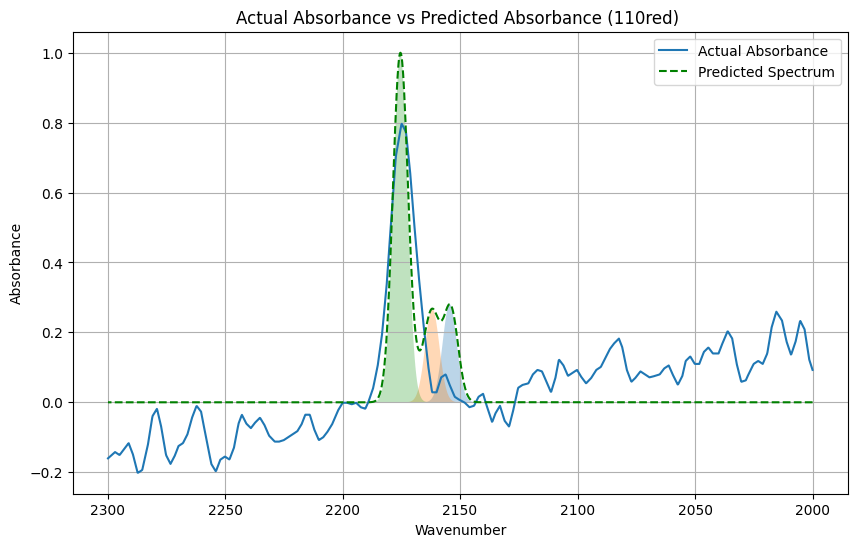

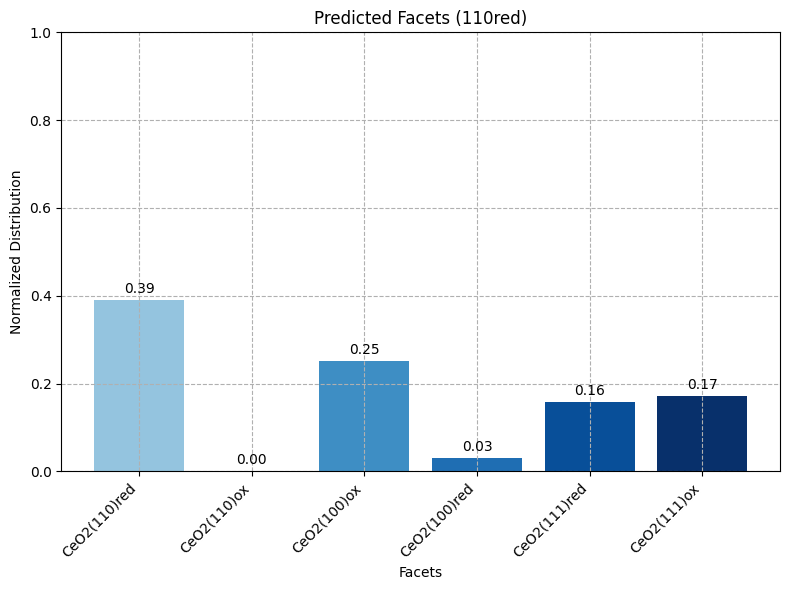

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
import random

np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Read the CSV file and preprocess the data
model = tf.keras.models.load_model('/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/CNN_LSTM_v1.h5')
#model = tf.keras.models.load_model('CNN_Model_6Freq_with_noise_v2.h5')

# CNN_Model_6Freq_with_noise


num_specific_frequencies = 6


# Function to generate a spectrum as a sum of Gaussians
def generate_spectru_gaussians(amplitudes, centers):
    widthG = 20
    x_range = np.arange(2000, 2299.8, 0.2)
    return np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / widthG) for i in range(len(centers))], axis=0)
# Function to generate multiple spectra as a sum of Gaussians
def generate_multiple_spectra(amplitudes, centers):
    widthG = 20
    x_range = np.arange(2300, 2000, -0.2)  # Generating inverse values

    # Initialize empty lists for frequencies and intensity ratios
    all_frequencies = []
    all_intensity_ratios = []
    all_spectra = []

    for i in range(len(centers)):
        if centers[i] == 2176:
            intensity_ratios = [1]
            frequencies = [2176]
        elif centers[i] == 2168:
            intensity_ratios = [1]
            frequencies = [2168]
        else:
            intensity_ratios = [1]
            frequencies = [list(specificFrequencies.keys())[i]]

        all_frequencies.append(frequencies)
        all_intensity_ratios.append(intensity_ratios)

        spectrum = np.sum([amplitudes[i] * np.exp(-(x_range - frequencies[j])**2 / widthG) * intensity_ratios[j] for j in range(len(frequencies))], axis=0)
        all_spectra.append(spectrum)

    final_spectrum = np.sum(all_spectra, axis=0)

    return final_spectrum, all_frequencies, all_intensity_ratios

# Define specific frequencies and corresponding classes/labels
specificFrequencies = {
    2175: 'CeO2(110)red',
    2170: 'CeO2(110)ox',
    2176: 'CeO2(100)ox',
    2168: 'CeO2(100)red',
    2162: 'CeO2(111)red',
    2154: 'CeO2(111)ox'
}


# Read the CSV file and preprocess the data
file_path = '/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/ExperimentalData//110red.csv'
# file_path = 'LC0027.0003.csv'
# file_path = 'combined_spectrum_0.3x100ox_1x111ox.csv'

data = pd.read_csv(file_path, header=None, names=["Wavenumber", "Absorbance"])
file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extracts the file name without extension


# Assuming spectrum_min and spectrum_max are defined earlier
spectrum_min, spectrum_max = 2000.0, 2300.0

data['Wavenumber'] = pd.to_numeric(data['Wavenumber'], errors='coerce')
data['Absorbance'] = pd.to_numeric(data['Absorbance'], errors='coerce')

# Filter data within the specified wavenumber range
filtered_data = data[(data['Wavenumber'] >= spectrum_min) & (data['Wavenumber'] <= spectrum_max)].copy()
filtered_data = filtered_data.dropna(subset=['Absorbance'])

# Preprocess the filtered data
filtered_data['Absorbance'] *= -1
min_value = np.min(filtered_data['Absorbance'] )
max_value = np.max(filtered_data['Absorbance'] )
spectraData_normalized = (filtered_data['Absorbance'] - min_value) / (max_value - min_value)
filtered_data['Absorbance'] =spectraData_normalized


# Calculating background value and subtracting it using spectrum_min and spectrum_max
background_data1 = filtered_data[(filtered_data['Wavenumber'] >= spectrum_min) & (filtered_data['Wavenumber'] <= 2140)]
background_data2 = filtered_data[(filtered_data['Wavenumber'] >= 2200) & (filtered_data['Wavenumber'] <= spectrum_max)]

background_value1 = background_data1['Absorbance'].mean()
background_value2 = background_data2['Absorbance'].mean()

# Using the average of these two values as the overall background value
background_value = np.mean([background_value1, background_value2])

filtered_data['Absorbance'] -= background_value


# Prepare data for interpolation
x = filtered_data['Wavenumber']
y = filtered_data['Absorbance']

# Normalize x-values for interpolation between 0 and 1
x_normalized = (x - spectrum_min) / (spectrum_max - spectrum_min)

# Initialize the array with zeros
interpolated_absorbance = np.zeros((num_specific_frequencies, 250))  # Initialize interpolated array

# Create an interpolation function
f = interp1d(x_normalized, y, kind='linear', fill_value="extrapolate")

# Define the new x-range for interpolation
new_x = np.linspace(0, 1, 1500)  # Adjust the number of points as needed

# Compute the interpolated y-values
interpolated_absorbance = f(new_x)

yy=interpolated_absorbance


interpolated_absorbance = interpolated_absorbance.reshape(1, -1, num_specific_frequencies)

predicted_amplitudes = model.predict(interpolated_absorbance )


# Flatten the predicted_amplitudes array for plotting
predicted_amplitudes_flat = predicted_amplitudes.flatten()

print (predicted_amplitudes)

# Use the previously defined function to generate spectrum
predicted_spectrum_1, _, _ = generate_multiple_spectra(predicted_amplitudes_flat, list(specificFrequencies.keys()))

# Use the second method to generate spectrum
predicted_spectrum_2 = generate_spectru_gaussians(predicted_amplitudes_flat, list(specificFrequencies.keys()))

# Normalize both spectra if needed
predicted_spectrum_1_shifted = predicted_spectrum_1 - predicted_spectrum_1.min()
normalized_predicted_spectrum_1 = predicted_spectrum_1_shifted / predicted_spectrum_1_shifted.max()

predicted_spectrum_2_shifted = predicted_spectrum_2 - predicted_spectrum_2.min()
normalized_predicted_spectrum_2 = predicted_spectrum_2_shifted / predicted_spectrum_2_shifted.max()


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import os

# Define the folder path
folder_path = 'Results'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the output filenames based on the CSV file name
csv_filename_without_extension = os.path.splitext(os.path.basename(file_path))[0]
spectrum_with_peaks_filename = os.path.join(folder_path, f'{csv_filename_without_extension}_spectrum_with_peaks.png')
distribution_plot_filename = os.path.join(folder_path, f'{csv_filename_without_extension}_distribution_plot.png')

wavenumbers_predicted = np.arange(2000, 2299.8, 0.2)
peaks_predicted, _ = find_peaks(normalized_predicted_spectrum_2, height=0.02, distance=10)  # Adjust parameters accordingly

# Plotting spectrum with peaks
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2000, 2299.8, 0.2), yy, label='Actual Absorbance')
plt.plot(np.arange(2000, 2299.8, 0.2), normalized_predicted_spectrum_2, 'g--', label='Predicted Spectrum')

for position in peaks_predicted:
    x_peak = np.arange(2000, 2299.8, 0.2)[position]
    y_peak = normalized_predicted_spectrum_2[position]

    # Generate Gaussian curve
    widthG = 18
    x_range = np.arange(2000, 2299.8, 0.2)
    gaussian_curve = np.exp(-(x_range - x_peak) ** 2 / widthG)

    # Normalize the Gaussian curve to the peak height
    normalized_gaussian_curve = gaussian_curve * y_peak / max(gaussian_curve)

    # Plot Gaussian normalization curve with filled area
    plt.fill_between(x_range, normalized_gaussian_curve, alpha=0.3)

    # Plotting vertical lines at the wavenumbers of peaks
# wavenumbers_of_peaks = wavenumbers_predicted[peaks_predicted]
# for wavenumber in wavenumbers_of_peaks:
#     plt.vlines(wavenumber, ymin=0, ymax=1, colors='orange', linestyles='dashed', label=f'Peak {wavenumber:.1f}')

plt.title(f'Actual Absorbance vs Predicted Absorbance ({file_name}) ')
plt.xlabel('Wavenumber')
plt.ylabel('Absorbance')
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)

# Save the spectrum with peaks plot in the folder
plt.savefig(spectrum_with_peaks_filename)

# Show the spectrum with peaks plot
plt.show()


# Plotting distribution
facet_amplitudes = predicted_amplitudes_flat[:num_specific_frequencies]

# Normalize the distribution
normalized_facet_amplitudes = facet_amplitudes / np.sum(facet_amplitudes)

colors = plt.cm.Blues(np.linspace(0.4, 1, 6))

plt.figure(figsize=(8, 6))
facets = list(specificFrequencies.values())
bars = plt.bar(facets, normalized_facet_amplitudes, color=colors)  # Assign colors to bars

plt.xlabel('Facets')
plt.ylabel('Normalized Distribution')
plt.title(f'Predicted Facets ({file_name})')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility

# Annotate each bar with its normalized amplitude value
for bar, amplitude in zip(bars, normalized_facet_amplitudes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{amplitude:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)  # Ensure Y-axis ranges from 0 to 1

plt.tight_layout()
plt.grid(True, which="both", ls="--")

# Save the distribution plot in the folder
plt.savefig(distribution_plot_filename)

# Show the distribution plot
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
